In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# For analysing Monte Carlo samples
from emcee import EnsembleSampler
from emcee.backends import HDFBackend

# For plotting Monte Carlo samples
from getdist import plots

In [2]:
file_path = "/home/olesya/Документы/A_Rabota/Rabota/Cosmological Tensions/Data/Pantheon+SH0ES.dat"
df = pd.read_csv(file_path, delimiter='\s+')

In [3]:
df.shape

(1701, 47)

In [4]:
df.head(10)

,CID,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,...,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
0,2011fe,51,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.74571,1.516210,...,0.1071,36,26.8859,0.864470,0.0991,1.4960,0.0381,0.005,1.0,0.003
1,2011fe,56,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.80286,1.517230,...,0.0579,101,88.3064,0.812220,0.0971,1.4960,-0.0252,0.003,1.0,0.004
2,2012cg,51,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.47030,0.781906,...,0.0278,165,233.5000,0.000358,0.0399,0.7134,0.0545,0.019,1.0,0.036
3,2012cg,56,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.49190,0.798612,...,0.0667,55,100.1220,0.000193,0.0931,0.7134,0.0622,0.028,1.0,0.040
4,1994DRichmond,50,0.00299,0.00084,0.00299,0.00004,0.00187,0.00004,11.52270,0.880798,...,0.0522,146,109.8390,0.988740,0.0567,0.6110,0.0650,0.009,1.0,0.006
5,1981B,50,0.00317,0.00084,0.00350,0.00001,0.00236,0.00001,11.54160,0.613941,...,0.2973,41,43.2260,0.376420,0.0732,0.5763,0.0206,0.007,1.0,0.013
6,2013aa,56,0.00331,0.00085,0.00478,0.00015,0.00411,0.00015,11.20740,0.594070,...,0.1580,31,27.5263,0.645500,0.1104,0.5586,0.0298,0.003,1.0,0.003
7,2013aa,5,0.00331,0.00085,0.00478,0.00015,0.00411,0.00015,11.29980,0.579622,...,0.1190,56,35.0505,0.987280,0.0620,0.5586,0.0727,0.007,1.0,0.003
8,2017cbv,5,0.00331,0.00085,0.00478,0.00015,0.00411,0.00015,11.14830,0.577815,...,0.0381,94,69.7345,0.971300,0.0580,0.5586,0.0516,0.004,1.0,0.003
9,2017cbv,18,0.00331,0.00085,0.00478,0.00015,0.00411,0.00015,11.25770,0.577916,...,0.0500,92,45.1690,0.999990,0.0607,0.5586,0.0216,0.003,1.0,0.003


As colunas que nós interessam:
 - redshift: `df['zCMB']`
 - distance: `df['MU_SH0ES']`
 - distance_error: `df['MU_SH0ES_ERR_DIAG']`
 - redshift_error: `df['zCMBERR']`

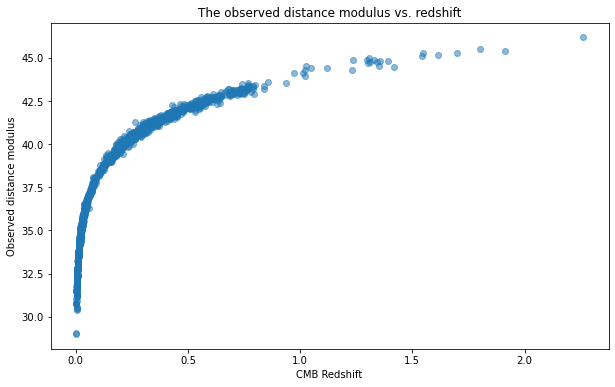

In [5]:
# Plot observed distance modulus vs redshift CMB

plt.figure(figsize=(10, 6))
plt.scatter(df['zCMB'], df['MU_SH0ES'], alpha=0.5)
plt.title('The observed distance modulus vs. redshift')
plt.xlabel('CMB Redshift')
plt.ylabel('Observed distance modulus')
plt.grid(False)

plt.show()

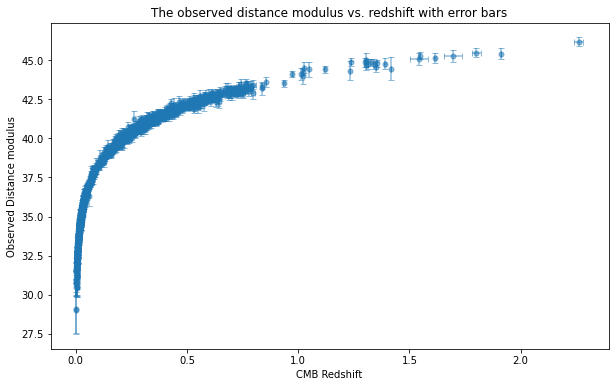

In [6]:
# Add error bars

plt.figure(figsize=(10, 6))
plt.errorbar(df['zCMB'], df['MU_SH0ES'], xerr=df['zCMBERR'], yerr=df['MU_SH0ES_ERR_DIAG'], fmt='o', alpha=0.5,
             capsize=3, markersize=5)
plt.title('The observed distance modulus vs. redshift with error bars')
plt.xlabel('CMB Redshift')
plt.ylabel('Observed Distance modulus')
plt.grid(False)

plt.show()

<AxesSubplot:>

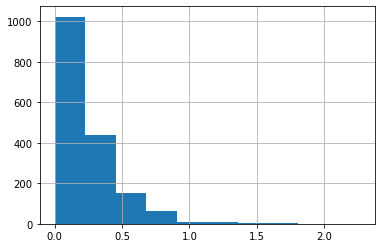

In [7]:
df['zCMB'].hist()

In [8]:
df['zCMB'].mean()

0.22108950617283932

In [9]:
df['zCMB'].min()

0.00122

In [10]:
df['zCMB'].max()

2.2613

## MCMC analysis using type Ia supernovae data


### The luminosity distance

The luminosity distance is a very important notion of distance for observation. It is based on the knowledge of the intrinsic luminosity _L_ of a source, which is therefore called _standard candle_. Type Ia supernovae are standard candles, for example.


The luminosity distance in a flat expanding Friedmann-Lemaitre-Robertson-Walker universe is defined as:

$$
d(z)=\frac{c}{H_0}\left[z+\frac{1}{2}(1-q_0)z^2-\frac{1}{6}(3q_0^2+q_0-j_0-1)(z^3)\right], 
$$

where $H_0$ is the Hubble constant, $q_0$ is a deceleration parameter and $j_0$ is a "jerk parameter" (third order derivative parameter).

Let's calculate the luminosity distance (up to second order) assuming the value of the Hubble constant $H_0$ as measured by the _SH0ES_ collaboration and the following parameters:

In [11]:
q0 = -0.55     #deceleration parameter
j0 = 1         #"jerk parameter" 
H0 = 73.04     #Hubble constant measured by the SH0ES collaboration, km/s/Mpc, deviation +-1.04
c =  299792    #speed of light, km/s

We use NumPy to perform vectorized operations and avoid using explicit loops.

In [12]:
# Transform df["zCMB"] to NumPy array

z_values = np.array(df["zCMB"])
z_values

array([1.22000e-03, 1.22000e-03, 2.56000e-03, ..., 1.80111e+00,
       1.91160e+00, 2.26130e+00])

In [13]:
z_values.shape

(1701,)

In [14]:
# Function to calculate the luminosity distance

def luminosity_distance(z):
    return c*z*(1+(1-q0)*(z/2)-(3*q0**2+q0-j0-1)*(z**2))/H0

# Call the function
lum_distance_array = luminosity_distance(z_values)
lum_distance_array

array([5.01222545e+00, 5.01222545e+00, 1.05284561e+01, ...,
       5.71016747e+04, 6.65630596e+04, 1.03501500e+05])

In [15]:
lum_distance_array.shape

(1701,)

### Theoretical prediction of distance modulus

The theoretical prediction of distance modulus $\mu$ is defined as:

$$
\mu=5\log_{10}\left(\frac{d(z)}{1 Mpc}\right)+25,
$$

where we used the Megaparsec (Mpc) as a more appropriate distance scale for cosmology.

In [16]:
# Function to calculate the distance modulos

def distance_modulos(lum_distance):
    return 5 * np.log10(lum_distance)  + 25

# Call the function
mu_model = distance_modulos(lum_distance_array)
mu_model

array([28.50015299, 28.50015299, 30.11182346, ..., 48.78324423,
       49.11616638, 50.07473321])

In [17]:
mu_model.shape

(1701,)

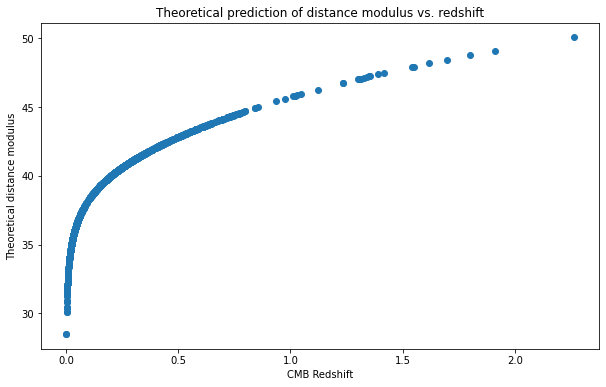

In [18]:
# Plot the theoretical prediction of distance modulus vs redshift

plt.figure(figsize=(10, 6))

plt.scatter(z_values, mu_model)
plt.title('Theoretical prediction of distance modulus vs. redshift') 
plt.xlabel('CMB Redshift')
plt.ylabel('Theoretical distance modulus')
plt.grid(False)
plt.show()

### Chi-square $\chi^2$ statistic


The $\chi^2$ function defined as

$$
\chi^2_{sne}=\left[\mu_{i,data}-\mu_{model}(z_i)\right]\Sigma^{-1}_{sne,ij}\left[\mu_{j,data}-\mu_{model}(z_j)\right],
$$

where $\mu_{i,data}$ and $\mu_{model}(z_i)$ are the _observed_ and _predicted_ distance moduli at the redshift $z_i$, respectively; $\Sigma^{-1}_{sne,ij}$ is the supernova covariance matrix from the Pantheon+ SH0ES collaboration (considering both statistical and systematic errors). First, we explore the covariance matrix.

### Covariance matrix

The format of the covariance (.cov) file is $NxN$ lines, where the first line gives the number of rows/columns in the matrix ($N=1701$). We are interested in the `STATONLY` matrix, it has only elements that correspond to the statistical distance uncertainties for individual SNe. Let's import the matrix and transform it into a Numpy array format.

In [19]:
# Import the matrix

cov_imp = pd.read_table("/home/olesya/Документы/A_Rabota/Rabota/Cosmological Tensions/Data/Pantheon+SH0ES_STATONLY.cov")

In [20]:
cov_imp.shape

(2893401, 1)

In [21]:
# Read the covariance matrix and store in a array

cov_matrix = [] 
for i in range(1701):
    row = []
    for j in range(1701*i,1701*(i+1)):
        row.append(cov_imp['1701'][j])
    cov_matrix.append(row)    

In [22]:
len(cov_matrix)

1701

In [23]:
# Verifying the covariance matrix 
cov_matrix[1700][1700]==cov_imp['1701'][2893400] 

True

In [24]:
# Transform the covariance matrix into a Numpy array format

cov_matrix = np.array(cov_matrix)
cov_matrix.shape

(1701, 1701)

In [25]:
cov_matrix[0]

array([0.03079947, 0.00551919, 0.00051552, ..., 0.        , 0.        ,
       0.        ])

### Likelihood

The likelihood is given by

$$
\mathcal{L}_{sne}(H_0,q_0,j_0,\mu_{data})=|2\pi\Sigma_{sne}|^{-\frac{1}{2}}e^{-\frac{1}{2}\chi^{2}}.
$$

Let's compute the Gaussian log-likelihood for the _observed_ and _predicted_ distance moduli at the redshift $z_i$, respectively.

In [41]:
# Function to compute the logarithm of the likelihood, return L

def compute_likelihood(covariance_matrix, mu_data, mu_model):
    eigen = np.linalg.eig(cov_matrix) # Eigenvalues of the covariant matrix 
    det_Sigma_sne = np.linalg.det(covariance_matrix)  # Calculate the determinant of the covariance matrix  
    inv_Sigma_sne = np.linalg.inv(covariance_matrix)  # Calculate the inverse of the covariance matrix  
    chi_squared = np.dot(np.dot((mu_data - mu_model), inv_Sigma_sne), (mu_data - mu_model)) # Calculate the chi-squared value

    return - 0.5 * (np.sum(np.log(np.absolute(eigen[1]))) + len(cov_matrix) * np.log(2*np.pi))- 0.5 * chi_squared
    

In [30]:
# df['MU_SH0ES'] to np.array

mu_data = np.array(df['MU_SH0ES'])
mu_data.shape

(1701,)

In [42]:
# Call the function

likelihood_value = compute_likelihood(cov_matrix, mu_data, mu_model)
print("Likelihood:", likelihood_value)

Likelihood: inf


<ipython-input-41-adba5f26b07c>:9: RuntimeWarning: divide by zero encountered in log
  return - 0.5 * (np.sum(np.log(np.absolute(eigen[1]))) + len(cov_matrix) * np.log(2*np.pi))- 0.5 * chi_squared


In [40]:
eigen = np.linalg.eig(cov_matrix)
np.log(np.absolute(eigen[1]))

<ipython-input-40-140efa69f1af>:2: RuntimeWarning: divide by zero encountered in log
  np.log(np.absolute(eigen[1]))


array([[-4.39839228, -4.6278794 , -5.96415148, ...,        -inf,
               -inf,        -inf],
       [-4.39650872, -4.62578529, -5.96193518, ...,        -inf,
               -inf,        -inf],
       [-3.77689219, -3.86343403, -4.87244901, ...,        -inf,
               -inf,        -inf],
       ...,
       [       -inf,        -inf,        -inf, ...,  0.        ,
               -inf,        -inf],
       [       -inf,        -inf,        -inf, ...,        -inf,
         0.        ,        -inf],
       [       -inf,        -inf,        -inf, ...,        -inf,
               -inf,  0.        ]])